In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from bs4 import BeautifulSoup
import re

### Extract data from [timeline of events](https://en.wikipedia.org/wiki/Timeline_of_the_21st_century)

Need to download the xml file on this [link](https://en.wikipedia.org/wiki/Special:Export/Timeline_of_the_21st_century)



In [133]:
path = 'data/events.xml'
with open(path, 'r') as f:
    data = f.read()

Bs_data = BeautifulSoup(data, "xml")

In [134]:
plain_txt = Bs_data.text
idx = plain_txt.find('===[[2015]]===')
plain_txt = plain_txt[idx:]

In [135]:
plain_txt = plain_txt.replace('\n\n', '\n')
plain_txt = plain_txt.replace('[', '')
plain_txt = plain_txt.replace(']', '')

In [136]:
plain_txt = plain_txt.split('\n')


In [137]:
new_list=[]
for txt in copy_txt:
    if 'see' in txt:
        continue
    if 'See' in txt:
        break
    if '=' not in txt:
        new_list.append(txt[2:])
    else:
        new_list.append(txt)


In [138]:
list_tuples = []
for i,element in enumerate(new_list):
    if '=' in element:
        year = element[3:7]
        continue
    list_tuples.append((year, element))

In [139]:
events_df = pd.DataFrame(list_tuples, columns =['Year', 'Event'])
events_df.head(10)

,Year,Event
0,2015,January 1: Five former Soviet Union countries ...
1,2015,January 3–January 7|7: Boko Haram perpetrates ...
2,2015,April 2: Al-Shabaab (militant group)|Al-Shabaa...
3,2015,April 25–May 3: The Death of Freddie Gray|deat...
4,2015,May 3: Floyd Mayweather Jr. vs. Manny Pacquiao.
5,2015,July 14: Iran nuclear deal|Joint Comprehensive...
6,2015,September 30: Russia begins Russian military i...
7,2015,November 30–December 12: 2015 United Nations C...
8,2015,A November 2015 Paris attacks|series of terror...
9,2015,April 2015 Nepal earthquake|A series May 2015 ...


# Exploration of channels data set

In [128]:
#channels
data_path = "data/"
data_channels_path = data_path + "df_channels_en.tsv.gz"
df_channels = pd.read_csv(data_channels_path, compression="infer", sep="\t")
df_channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [87]:
def check_nan(df):
    check = False
    for col in df.columns:
        if df[col].isnull().values.any():
            print(col)
            check = True
    if not check:
            print('None')

In [88]:
check_nan(df_channels)

category_cc
join_date
name_cc


In [89]:
# Remove rows with NaN values
df = df_channels.copy()
df.dropna(axis=0, inplace=True)
print('Original dataset length: {} \nLength of new dataset: {}'.format(len(df_channels), len(df)))

Original dataset length: 136470 
Length of new dataset: 136331


In [90]:
check_nan(df)

None


In [91]:
#convert date column to datetime
df['join_date'] = pd.to_datetime(df['join_date'], format='%Y-%m-%d').dt.to_period('M')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136331 entries, 0 to 136469
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype    
---  ------              --------------   -----    
 0   category_cc         136331 non-null  object   
 1   join_date           136331 non-null  period[M]
 2   channel             136331 non-null  object   
 3   name_cc             136331 non-null  object   
 4   subscribers_cc      136331 non-null  int64    
 5   videos_cc           136331 non-null  int64    
 6   subscriber_rank_sb  136331 non-null  float64  
 7   weights             136331 non-null  float64  
dtypes: float64(2), int64(2), object(3), period[M](1)
memory usage: 9.4+ MB


In [92]:
df.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [93]:
df.groupby(by=['category_cc'])['category_cc'].count().sort_values(ascending=False)

category_cc
Music                    24283
Entertainment            22944
Gaming                   20141
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: category_cc, dtype: int64

<AxesSubplot:title={'center':'Number of channels per category'}, xlabel='category_cc'>

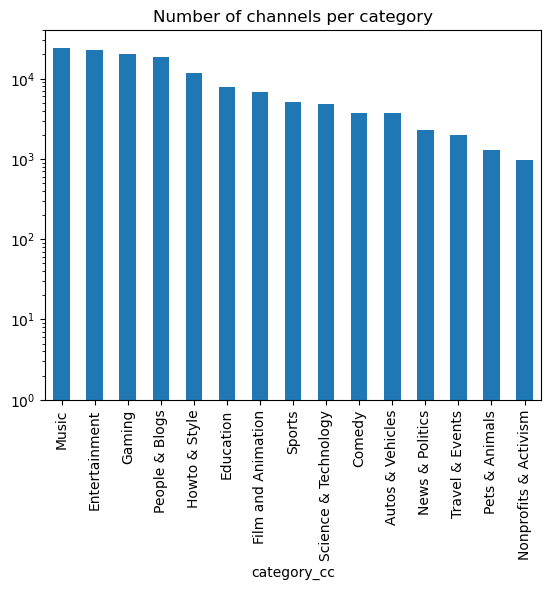

In [94]:
df.groupby(by=['category_cc'])['category_cc'].count().sort_values(ascending=False).plot.bar(title='Number of channels per category', log=True)

<AxesSubplot:title={'center':'Number of subscribers per category'}, xlabel='category_cc'>

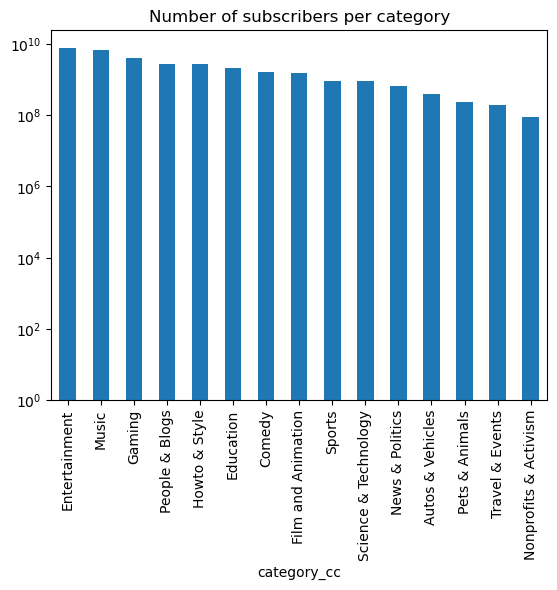

In [95]:
df.groupby(by=['category_cc'])['subscribers_cc'].sum().sort_values(ascending=False).plot.bar(title='Number of subscribers per category', log=True)

<AxesSubplot:title={'center':'number of videos per category'}, xlabel='category_cc'>

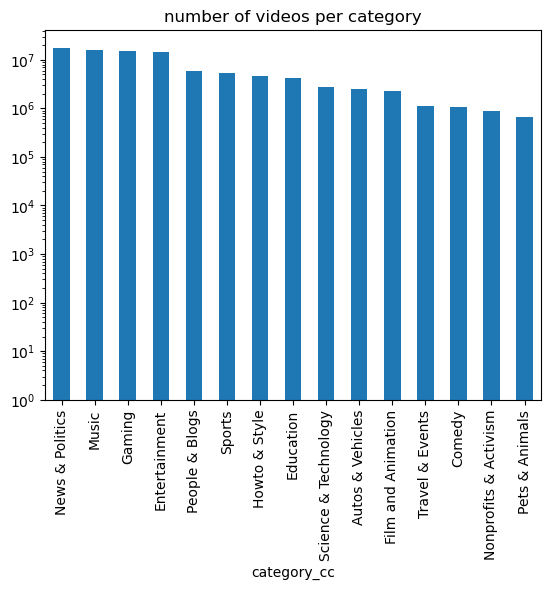

In [96]:
df.groupby(by=['category_cc'])['videos_cc'].sum().sort_values(ascending=False).plot.bar(title='number of videos per category',log=True)

In [97]:
#Create a df counting the number of channels created per month for each category
monthly_count_df = df.groupby(by=['category_cc'])['join_date'].value_counts().unstack().fillna(0).transpose()
monthly_count_df.head(5)

category_cc,Autos & Vehicles,Comedy,Education,Entertainment,Film and Animation,Gaming,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events
join_date,,,,,,,,,,,,,,,
2004-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2005-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005-06,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2005-07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


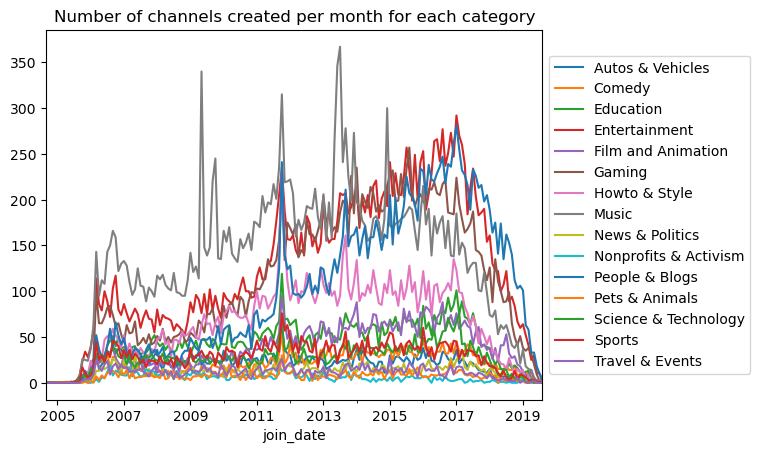

In [100]:
monthly_count_df.plot(title='Number of channels created per month for each category')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

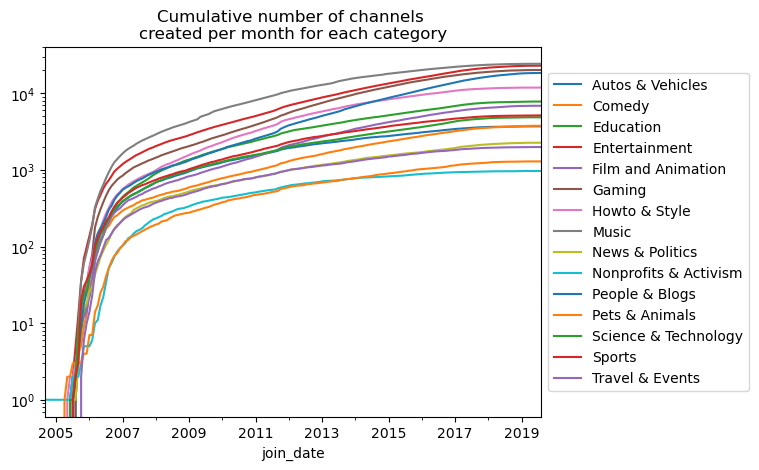

In [99]:
monthly_count_df.cumsum().plot(title='Cumulative number of channels \ncreated per month for each category', logy=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Exploration of time series df of channels

In [117]:
#channels timeseries for each week
data_timeseries_path = data_path + "df_timeseries_en.tsv.gz"
df_timeseries = pd.read_csv(data_timeseries_path, compression="infer", sep="\t")
df_timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [118]:
check_nan(df_timeseries)

category


In [119]:
df = df_timeseries.dropna(axis=0)
print('Original dataset length: {} \nLength of new dataset: {}'.format(len(df_timeseries), len(df)))

Original dataset length: 18872499 
Length of new dataset: 18851915


In [136]:
#convert date column to datetime
df = df_timeseries.copy()
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d').dt.date
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18872499 entries, 0 to 18872498
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   channel       object        
 1   category      object        
 2   datetime      datetime64[ns]
 3   views         float64       
 4   delta_views   float64       
 5   subs          float64       
 6   delta_subs    float64       
 7   videos        int64         
 8   delta_videos  int64         
 9   activity      int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 1.4+ GB


In [142]:
df.tail(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
18872494,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-02,6.012938e+06,232418.277778,61268.611111,1305.611111,278,2,10
18872495,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-09,6.244579e+06,231640.888889,62631.666667,1363.055556,287,9,13
18872496,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-16,6.480902e+06,236322.933333,64010.000000,1378.333333,294,7,16
18872497,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-23,6.745317e+06,264415.200000,65480.000000,1470.000000,301,7,15
18872498,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-30,6.987738e+06,242420.771429,66542.857143,1062.857143,308,7,16


<AxesSubplot:title={'center':'total views per category'}, xlabel='category'>

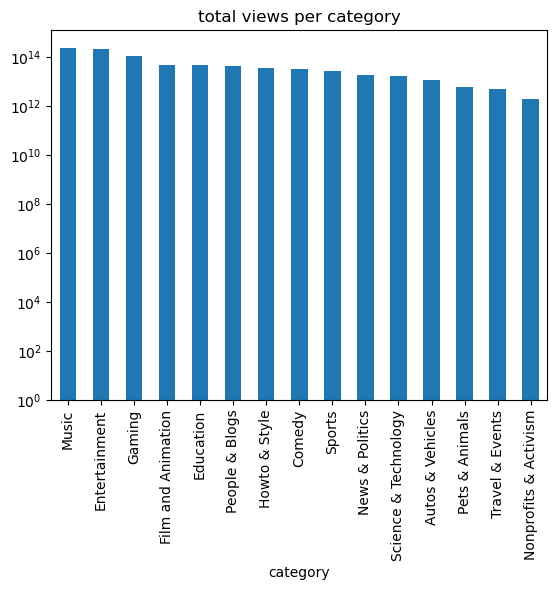

In [138]:
df.groupby(by=['category'])['views'].sum().sort_values(ascending=False).plot.bar(title='total views per category',log=True)

In [139]:
weekly_total_views = df.groupby(by=['category', 'datetime'])['views'].sum().unstack().fillna(0).transpose()

In [140]:
weekly_total_views['Autos & Vehicles'].tail(10)

datetime
2019-07-29    1.090882e+11
2019-08-05    1.097152e+11
2019-08-12    1.099175e+11
2019-08-19    1.105491e+11
2019-08-26    1.111923e+11
2019-09-02    1.116592e+11
2019-09-09    1.121785e+11
2019-09-16    1.128157e+11
2019-09-23    1.134574e+11
2019-09-30    8.551406e+10
Name: Autos & Vehicles, dtype: float64

In [141]:
monthly_total_views = weekly_total_views.resample('M').sum()
monthly_total_views.head(10)

category,Autos & Vehicles,Comedy,Education,Entertainment,Film and Animation,Gaming,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events
datetime,,,,,,,,,,,,,,,
2015-01-31,0.000000e+00,0.000000e+00,0.000000e+00,2.160873e+08,4.089590e+06,2.632912e+08,9.924360e+08,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2015-02-28,0.000000e+00,0.000000e+00,0.000000e+00,2.990728e+08,5.559444e+06,3.414193e+08,1.319065e+09,0.000000e+00,0.000000e+00,0.00000,2.679363e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2015-03-31,0.000000e+00,0.000000e+00,1.816008e+07,4.031583e+08,7.101516e+06,4.753507e+08,1.648865e+09,0.000000e+00,0.000000e+00,0.00000,1.362671e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2015-04-30,0.000000e+00,0.000000e+00,3.877397e+07,3.582277e+08,5.798090e+06,4.137433e+08,1.320136e+09,1.740861e+07,0.000000e+00,0.00000,1.113524e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2015-05-31,0.000000e+00,0.000000e+00,4.304648e+07,3.955013e+08,5.896031e+06,4.435342e+08,1.320580e+09,6.568360e+06,0.000000e+00,0.00000,1.197064e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2015-06-30,9.561281e+06,0.000000e+00,5.827927e+07,5.991139e+08,7.532473e+06,6.040659e+08,1.667692e+09,3.267528e+07,0.000000e+00,0.00000,1.766215e+07,0.000000e+00,0.000000e+00,1.093476e+07,0.0
2015-07-31,9.043204e+06,2.609930e+06,5.034065e+07,5.324453e+08,6.096920e+06,5.218050e+08,1.356636e+09,9.391240e+07,0.000000e+00,0.00000,1.409284e+07,0.000000e+00,0.000000e+00,1.172147e+07,0.0
2015-08-31,1.283627e+07,5.214078e+06,6.885262e+07,6.937548e+08,7.668118e+06,6.950896e+08,1.701977e+09,1.716614e+08,0.000000e+00,0.00000,2.088883e+07,1.782805e+08,0.000000e+00,3.226497e+07,0.0
2015-09-30,4.857534e+07,5.733573e+06,5.962818e+07,5.862861e+08,6.206406e+06,5.882381e+08,1.428475e+09,2.431108e+08,0.000000e+00,0.00000,1.512888e+08,2.379046e+08,0.000000e+00,6.713180e+07,0.0


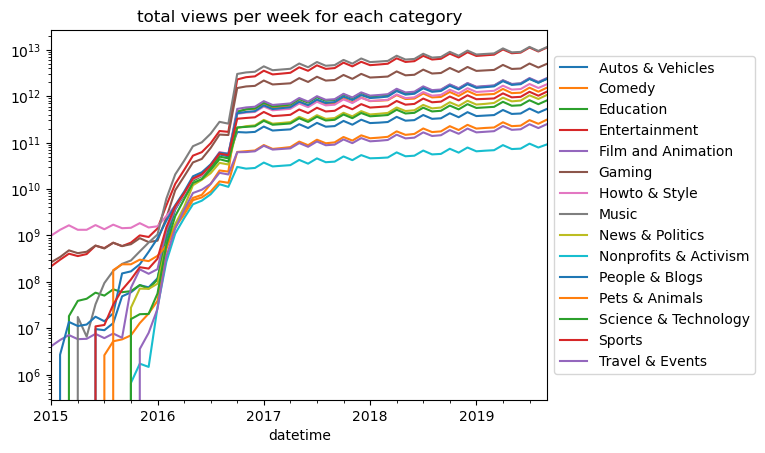

In [143]:
#Graph looks a bit weird
monthly_total_views.plot(title='total views per week for each category', logy=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Exploration of number of comments per videos

In [115]:
#Number of comments per videos
data_num_comments_path = data_path + "num_comments.tsv.gz"
df_num_comments = pd.read_csv(data_num_comments_path, compression="infer", sep="\t")
df_num_comments.head()

,display_id,num_comms
0,SBqSc91Hn9g,0.0
1,UuugEl86ESY,0.0
2,oB4c-yvnbjs,48.0
3,ZaV-gTCMV8E,6.0
4,cGvL7AvMfM0,5.0


# Exploration of the metadata df of videos

In [10]:
# Opening JSON file in chunks and converts it to csv. Don't generate files if you don't need to.
chunksize = 10 ** 5
i = 0
for chunk in pd.read_json('data/yt_metadata_en.jsonl.gz', lines=True,  chunksize=chunksize):
    i +=1
    file = pd.DataFrame(chunk)
    chunks_dir = 'data/metadata_chunks'
    if not os.path.isdir(chunks_dir):
        os.mkdir(chunks_dir)
    file.to_csv(chunks_dir+'/metadata_chunks_'+str(i)+'.csv.gz')

In [15]:
path = 'data/metadata_chunks/'
csv_files = glob.glob(path+'*.csv.gz')
csv_files

['data/metadata_chunks/metadata_chunks_141.csv.gz',
 'data/metadata_chunks/metadata_chunks_610.csv.gz',
 'data/metadata_chunks/metadata_chunks_710.csv.gz',
 'data/metadata_chunks/metadata_chunks_28.csv.gz',
 'data/metadata_chunks/metadata_chunks_55.csv.gz',
 'data/metadata_chunks/metadata_chunks_36.csv.gz',
 'data/metadata_chunks/metadata_chunks_1.csv.gz',
 'data/metadata_chunks/metadata_chunks_122.csv.gz',
 'data/metadata_chunks/metadata_chunks_673.csv.gz',
 'data/metadata_chunks/metadata_chunks_395.csv.gz',
 'data/metadata_chunks/metadata_chunks_295.csv.gz',
 'data/metadata_chunks/metadata_chunks_702.csv.gz',
 'data/metadata_chunks/metadata_chunks_602.csv.gz',
 'data/metadata_chunks/metadata_chunks_153.csv.gz',
 'data/metadata_chunks/metadata_chunks_299.csv.gz',
 'data/metadata_chunks/metadata_chunks_399.csv.gz',
 'data/metadata_chunks/metadata_chunks_47.csv.gz',
 'data/metadata_chunks/metadata_chunks_24.csv.gz',
 'data/metadata_chunks/metadata_chunks_59.csv.gz',
 'data/metadata_chun

In [16]:
# only reads specific columns since not all information is necessary.
# also only reads in subset of current dataframes since it is super massive
df = pd.DataFrame()
counter = 0
#append all files together
for file in csv_files:
            df_temp = pd.read_csv(file, usecols = ['categories','channel_id', 'description', 'title', 'tags'])
            df = df.append(df_temp, ignore_index=True)
            counter += 1
            if counter == 1:
                break
df

/var/folders/yb/s0f6sw2927z0fg31yb0l2zyc0000gn/T/ipykernel_16479/708807537.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp, ignore_index=True)


,categories,channel_id,description,tags,title
0,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Title says it all...Well I guess you all know ...,"Integra Type R,Crash Accident,Accident,Integra...",I Got Into An Accident Again In My Integra!
1,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Time to start planning this engine build out! ...,"Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Engine Build-Planning Stage
2,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,So you think you know A lot about the Integra?...,"10 things you did not know about the integra,I...",10 Things You Didn't Know About The Honda/Acur...
3,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Part 2 of the install! I also changed the oil ...,"Project Integra,Integra Type R,Miroshi,Coilove...",Project Integra Track Car Build Episode 20- Co...
4,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"So I was able to do the fronts, but the rears ...","Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Track Car Build Episode 19-Tei...
...,...,...,...,...,...
99995,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The light show kicked off in Shenzhen Special ...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...",Shenzhen's 40th Anniversary Light Show kicked ...
99996,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,More than 400 meters long! China's new 16-carr...,"CCTV,CGTN,CCTVNews,News,ChinaNews,Technology,S...",China's longer Fuxing bullet train debuts on S...
99997,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,110 people have been hospitalized in Afghanist...,"CCTV,CGTN,CCTVNews,News,WorldNews,schoolgirlpo...",Over 60 schoolgirls poisoned in Parwan Provinc...
99998,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The African Union is holding its 31st summit i...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...","Xi Jinping hails AU's role in promoting unity,..."


In [17]:
# removes duplicates of videos 
df.drop_duplicates(subset=['title'])

,categories,channel_id,description,tags,title
0,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Title says it all...Well I guess you all know ...,"Integra Type R,Crash Accident,Accident,Integra...",I Got Into An Accident Again In My Integra!
1,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Time to start planning this engine build out! ...,"Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Engine Build-Planning Stage
2,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,So you think you know A lot about the Integra?...,"10 things you did not know about the integra,I...",10 Things You Didn't Know About The Honda/Acur...
3,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Part 2 of the install! I also changed the oil ...,"Project Integra,Integra Type R,Miroshi,Coilove...",Project Integra Track Car Build Episode 20- Co...
4,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"So I was able to do the fronts, but the rears ...","Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Track Car Build Episode 19-Tei...
...,...,...,...,...,...
99995,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The light show kicked off in Shenzhen Special ...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...",Shenzhen's 40th Anniversary Light Show kicked ...
99996,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,More than 400 meters long! China's new 16-carr...,"CCTV,CGTN,CCTVNews,News,ChinaNews,Technology,S...",China's longer Fuxing bullet train debuts on S...
99997,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,110 people have been hospitalized in Afghanist...,"CCTV,CGTN,CCTVNews,News,WorldNews,schoolgirlpo...",Over 60 schoolgirls poisoned in Parwan Provinc...
99998,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The African Union is holding its 31st summit i...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...","Xi Jinping hails AU's role in promoting unity,..."


In [18]:
df["video_info"] = df['title'].astype(str) +": "+ df["description"]
df

,categories,channel_id,description,tags,title,video_info
0,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Title says it all...Well I guess you all know ...,"Integra Type R,Crash Accident,Accident,Integra...",I Got Into An Accident Again In My Integra!,I Got Into An Accident Again In My Integra!: T...
1,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Time to start planning this engine build out! ...,"Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Engine Build-Planning Stage,Project Integra Engine Build-Planning Stage: T...
2,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,So you think you know A lot about the Integra?...,"10 things you did not know about the integra,I...",10 Things You Didn't Know About The Honda/Acur...,10 Things You Didn't Know About The Honda/Acur...
3,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,Part 2 of the install! I also changed the oil ...,"Project Integra,Integra Type R,Miroshi,Coilove...",Project Integra Track Car Build Episode 20- Co...,Project Integra Track Car Build Episode 20- Co...
4,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"So I was able to do the fronts, but the rears ...","Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Track Car Build Episode 19-Tei...,Project Integra Track Car Build Episode 19-Tei...
...,...,...,...,...,...,...
99995,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The light show kicked off in Shenzhen Special ...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...",Shenzhen's 40th Anniversary Light Show kicked ...,Shenzhen's 40th Anniversary Light Show kicked ...
99996,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,More than 400 meters long! China's new 16-carr...,"CCTV,CGTN,CCTVNews,News,ChinaNews,Technology,S...",China's longer Fuxing bullet train debuts on S...,China's longer Fuxing bullet train debuts on S...
99997,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,110 people have been hospitalized in Afghanist...,"CCTV,CGTN,CCTVNews,News,WorldNews,schoolgirlpo...",Over 60 schoolgirls poisoned in Parwan Provinc...,Over 60 schoolgirls poisoned in Parwan Provinc...
99998,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,The African Union is holding its 31st summit i...,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...","Xi Jinping hails AU's role in promoting unity,...","Xi Jinping hails AU's role in promoting unity,..."


In [19]:
df = df.drop(['title'],  axis=1)
df = df.drop(['description'], axis=1)
df

,categories,channel_id,tags,video_info
0,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"Integra Type R,Crash Accident,Accident,Integra...",I Got Into An Accident Again In My Integra!: T...
1,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Engine Build-Planning Stage: T...
2,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"10 things you did not know about the integra,I...",10 Things You Didn't Know About The Honda/Acur...
3,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"Project Integra,Integra Type R,Miroshi,Coilove...",Project Integra Track Car Build Episode 20- Co...
4,Autos & Vehicles,UCgwfT0I2eP17yqVFBiW44nw,"Project Integra,Tj Hunt,Offbeat Garage,That Du...",Project Integra Track Car Build Episode 19-Tei...
...,...,...,...,...
99995,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...",Shenzhen's 40th Anniversary Light Show kicked ...
99996,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,"CCTV,CGTN,CCTVNews,News,ChinaNews,Technology,S...",China's longer Fuxing bullet train debuts on S...
99997,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,"CCTV,CGTN,CCTVNews,News,WorldNews,schoolgirlpo...",Over 60 schoolgirls poisoned in Parwan Provinc...
99998,News & Politics,UCgrNz-aDmcr2uuto8_DL2jg,"CCTV,CGTN,CCTVNews,News,ChinaNews,WorldNews,Po...","Xi Jinping hails AU's role in promoting unity,..."


In [192]:
df_metadata["dummy"] = 1

In [205]:
df_cat_count = df_metadata.groupby("categories", as_index=False).sum()
df_cat_count

,categories,dislike_count,duration,like_count,view_count,dummmy
0,,1.925700e+04,1137880,1.589750e+05,1.564009e+08,1522
1,Autos & Vehicles,6.790556e+07,852657449,9.563003e+08,1.230943e+11,2256967
2,Comedy,2.332550e+08,596953237,6.134163e+09,3.450391e+11,1172503
3,Education,3.853637e+08,3692708661,2.881362e+09,5.023918e+11,3795564
4,Entertainment,1.479342e+09,7666398193,2.014055e+10,2.287748e+12,12276397
5,Film & Animation,3.143058e+08,1505306945,3.737847e+09,5.762808e+11,2359736
6,Gaming,7.142940e+08,19654718199,1.735133e+10,1.042503e+12,13720303
7,Howto & Style,2.924541e+08,2322773279,5.790819e+09,4.206668e+11,3968127
8,Movies,4.580000e+02,1029,1.004300e+04,7.124480e+05,5
9,Music,8.917641e+08,3913741624,1.927046e+10,2.474987e+12,8305003


In [206]:
df_cat_count.drop(labels=[0,8,15], axis=0, inplace=True)

In [209]:
df_cat_count.columns

Index(['categories', 'dislike_count', 'duration', 'like_count', 'view_count',
       'dummmy'],
      dtype='object')

<AxesSubplot:xlabel='categories'>

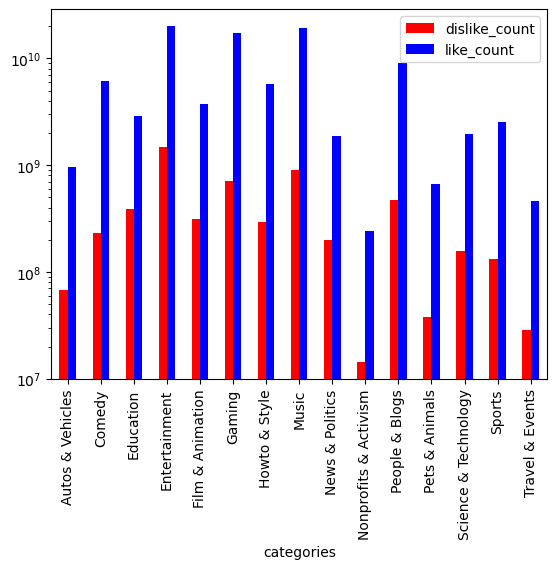

In [221]:
df_cat_count.plot.bar(x='categories', y=['dislike_count', 'like_count'], logy=True, color=('r', 'b'))

<AxesSubplot:xlabel='categories'>

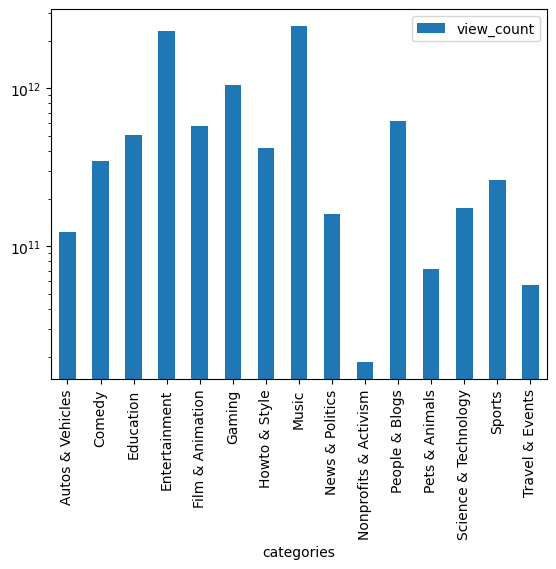

In [214]:
df_cat_count.plot.bar(x='categories', y=['view_count'], logy=True)

<AxesSubplot:xlabel='categories'>

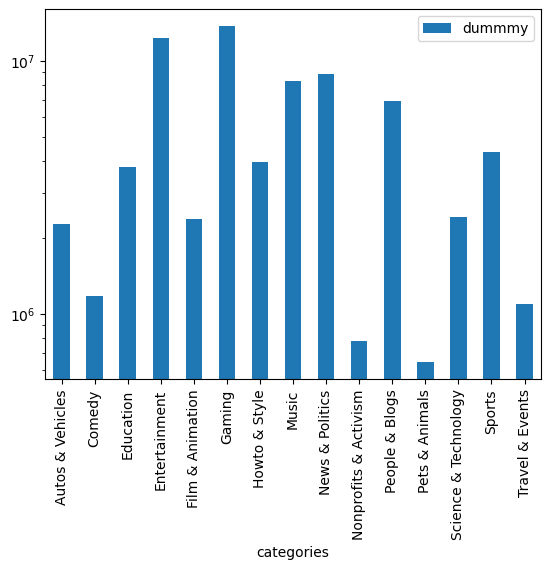

In [216]:
df_cat_count.plot.bar(x='categories', y=['dummmy'], logy=True)

<AxesSubplot:xlabel='categories'>

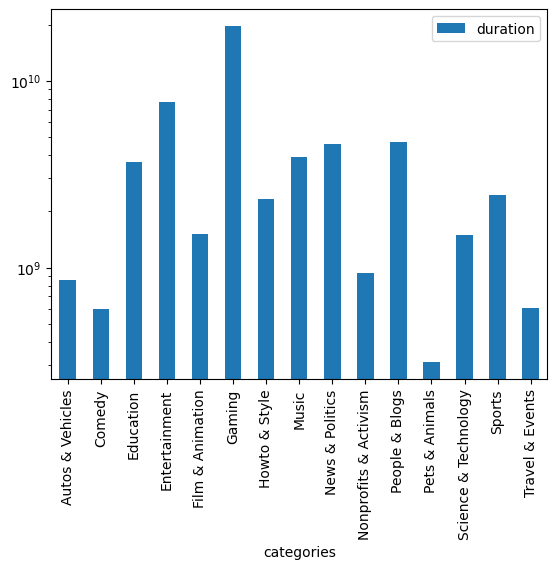

In [217]:
df_cat_count.plot.bar(x='categories', y=['duration'], logy=True)